## Inference

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import numpy as np
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from coco_dataset import COCODataset_Aug
from transform_util import Compose, RandomHorizontalFlip, PILToTensor, ToDtype, RandomPhotometricDistort
from torch.utils.data import DataLoader

from utils import *
from make_args import Args

from PIL import Image
import cv2
from tqdm import tqdm

from eval_utils.metric import get_inference_metrics_from_df, summarise_inference_metrics
from eval_utils.coco_metric import get_coco_from_dfs

import pandas as pd

- load config json

In [2]:
# load config.json
args = Args('./config/03_Aug_ResNet50FPN_Backbone.json')

- validation dataset

In [3]:
def collator(batch):
    return tuple(zip(*batch))

In [4]:
val_transform = Compose(
    [
        PILToTensor(),
        ToDtype(scale=True, dtype=torch.float)
    ]
)
val_dataset = COCODataset_Aug(args.data_path, train=False, transform=val_transform)
val_dataloader = DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True, collate_fn=collator, num_workers=args.num_workers
)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


- 모델 로드

In [5]:
weights_path = './model_result/03_Aug_ResNet50FPN_Backbone/Augment_ResNet50FPN_model.pth'
weights = torch.load(weights_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

if args.backbone == 'vgg16':
    backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
    backbone.out_channels = 512

    anchor_generator = rpn.AnchorGenerator(sizes=(args.anchor_sizes,), aspect_ratios=(args.anchor_ratio,))
    roi_pooler = ops.MultiScaleRoIAlign(featmap_names=["0"], output_size=args.pooler_output_size, sampling_ratio=args.pooler_sampling_ratio)

    model = FasterRCNN(backbone=backbone, 
                       num_classes=len(val_dataset._get_categories()), 
                       rpn_anchor_generator=anchor_generator, 
                       box_roi_pool=roi_pooler ).to(device)
    
elif args.backbone == 'resnet50fpn':
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = FasterRCNN(backbone, num_classes=len(val_dataset._get_categories())).to('cuda')

model.load_state_dict(weights)
model.to(device)
model.eval()

/home/aicombined/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/aicombined/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aicombined/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

- loss check

In [6]:
loss_dict = np.load('./model_result/03_Aug_ResNet50FPN_Backbone/Augment_ResNet50FPN_model.npy', allow_pickle=True).item()

In [7]:
loss_dict

{'train_loss': [0.8836617045280374,
  0.7505376952569304,
  0.7160477692578768,
  0.6977532844177728,
  0.6853717464558716,
  0.6757987771467389,
  0.6667532314960539,
  0.6584337467887093,
  0.6507186315062183,
  0.6421114512480188,
  0.6337348937470837,
  0.6249410708590291,
  0.6161962948474707,
  0.6068364666366455,
  0.5980740758882797],
 'val_loss': [0.7742810161221586,
  0.7308051543060528,
  0.7085613308050136,
  0.6948343358681159,
  0.6887517673277893,
  0.684090534270243,
  0.6790916125782087,
  0.6693359991604754,
  0.6638457660889779,
  0.6486705519283049,
  0.6490514394142612,
  0.6426325617704137,
  0.6343608669130213,
  0.6186253867670292,
  0.6251016822259915]}

- inference

In [8]:
_cate_dict = val_dataset.new_categories
cate_dict = {}
for key, value in _cate_dict.items():
    cate_dict[value] = key

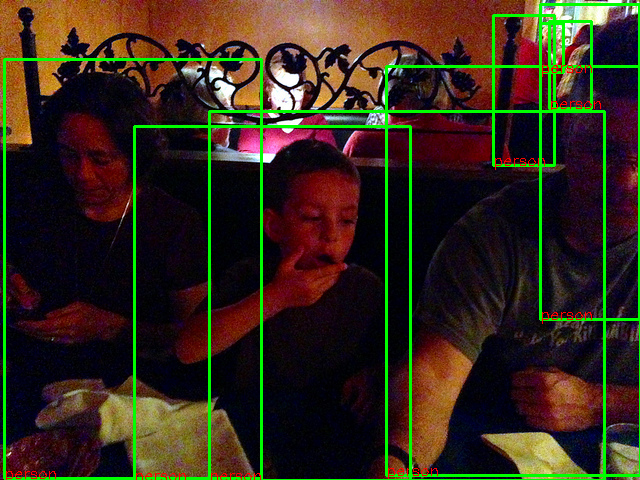

In [10]:
se_idx = -1
threshold = 0.5
with torch.no_grad():
    image, target = val_dataset[se_idx]
    image = [image.to(device)]
    outputs = model(image)

    boxes = outputs[0]["boxes"].to("cpu").numpy()
    labels = outputs[0]["labels"].to("cpu").numpy()
    scores = outputs[0]["scores"].to("cpu").numpy()

    boxes = boxes[scores >= threshold].astype(np.int32)
    labels = labels[scores >= threshold]
    scores = scores[scores >= threshold]

    gtboxes = target["boxes"].numpy()
    gtlabels = target["labels"].numpy()

draw_img = np.uint8(np.transpose(image[0].data.cpu().numpy(), (1, 2, 0)) * 255)
for i, bbox in enumerate(boxes):
    cv2.rectangle(draw_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    cv2.putText(draw_img, cate_dict[labels[i]], (bbox[0], bbox[3]), cv2.FONT_ITALIC, 0.5, (255, 0, 0))
Image.fromarray(draw_img)

## Evaluation

In [12]:
gt_lists = []
pred_lists = []
stop_flag = 0

with torch.no_grad():
    model.eval()
    fileidx = 1
    # stop_flag += 1
    for images, targets in tqdm(val_dataloader, total=len(val_dataloader)):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        # filename (arbitraily)
        filename = str(fileidx).zfill(6) + '.jpg'
        fileidx += 1
        
        # gt 작업
        gt_boxes = targets[0]['boxes'].data.cpu().numpy()
        gt_labels = targets[0]['labels'].data.cpu().numpy()

        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            x, y, w, h = gt_box
            x_min, y_min, x_max, y_max = x, y, x+w, y+h
            gt_list = [x_min, y_min, x_max, y_max, cate_dict[gt_label], filename]
            gt_lists.append(gt_list)

        # inference 작업
        pred_boxes = outputs[0]['boxes'].data.cpu().numpy()
        pred_labels = outputs[0]['labels'].data.cpu().numpy()
        pred_scores = outputs[0]['scores'].data.cpu().numpy()

        for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
            x, y, w, h = pred_box
            x_min, y_min, x_max, y_max = x, y, x+w, y+h
            pred_list = [x_min, y_min, x_max, y_max, cate_dict[pred_label], pred_score, filename]
            pred_lists.append(pred_list)

        # stop_flag += 1
        # if stop_flag == 300:
        #     break

100%|██████████| 1238/1238 [06:27<00:00,  3.19it/s]


- make dataframe

In [13]:
gt_lists = np.array(gt_lists)
pred_lists = np.array(pred_lists)

preds_df = pd.DataFrame()
preds_df['xmin'] = np.array(pred_lists[:,0], dtype=np.float32)
preds_df['ymin'] = np.array(pred_lists[:,1], dtype=np.float32)
preds_df['xmax'] = np.array(pred_lists[:,2], dtype=np.float32)
preds_df['ymax'] = np.array(pred_lists[:,3], dtype=np.float32)
preds_df['label'] = pred_lists[:,4]
preds_df['score'] = np.array(pred_lists[:,5], dtype=np.float32)
preds_df['image_name'] = pred_lists[:,6]

labels_df = pd.DataFrame()
labels_df['xmin'] = np.array(gt_lists[:,0], dtype=np.float32)
labels_df['ymin'] = np.array(gt_lists[:,1], dtype=np.float32)
labels_df['xmax'] = np.array(gt_lists[:,2], dtype=np.float32)
labels_df['ymax'] = np.array(gt_lists[:,3], dtype=np.float32)
labels_df['label'] = gt_lists[:,4]
labels_df['image_name'] = gt_lists[:,5]

- custom evaluation

In [14]:
infer_df = get_inference_metrics_from_df(preds_df, labels_df)
class_summary_df = summarise_inference_metrics(infer_df)

In [15]:
class_summary_df

,class,TP,FP,FN,Total,Precision,Recall
0,airplane,167,102,0,269,0.620818,1.000000
1,apple,205,305,3,513,0.401961,0.985577
2,backpack,344,1123,2,1469,0.234492,0.994220
3,banana,662,471,3,1136,0.584289,0.995489
4,baseball bat,83,137,0,220,0.377273,1.000000
...,...,...,...,...,...,...,...
75,tv,272,328,4,604,0.453333,0.985507
76,umbrella,291,215,8,514,0.575099,0.973244
77,vase,414,776,0,1190,0.347899,1.000000
78,wine glass,252,156,3,411,0.617647,0.988235


- coco evaluation

In [16]:
res = get_coco_from_dfs(preds_df, labels_df, False)

creating index...
index created!
Loading and preparing results...
DONE (t=0.44s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.71s).
Accumulating evaluation results...
DONE (t=1.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.651
 Average Recall     (AR) @[ IoU=0.5